In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Tải bộ dữ liệu MNIST
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Đặt seed ngẫu nhiên để tái lập kết quả
np.random.seed(0)

# Chia dữ liệu thành tập huấn luyện và tập xác thực
train_indices = np.random.choice(60000, 50000, replace=False)
valid_indices = np.array([i for i in range(60000) if i not in train_indices])

# Tạo tập huấn luyện và tập xác thực
X_train = X_train_full[train_indices]
y_train = y_train_full[train_indices]
X_valid = X_train_full[valid_indices]
y_valid = y_train_full[valid_indices]

print(X_train.shape, X_valid.shape, X_test.shape)

X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

(50000, 28, 28) (10000, 28, 28) (10000, 28, 28)


In [24]:
# Định nghĩa kích thước ảnh và số lượng nhãn
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    """
    Định dạng lại dữ liệu bằng cách làm phẳng ảnh và chuyển đổi nhãn thành one-hot encoding.
    """
    # Làm phẳng ảnh thành dạng (số mẫu, 784)
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Chuyển đổi nhãn thành one-hot encoding
    labels = tf.keras.utils.to_categorical(labels, num_labels)
    return dataset, labels

# Định dạng lại dữ liệu huấn luyện, xác thực và kiểm tra
X_train, y_train = reformat(X_train, y_train)
X_valid, y_valid = reformat(X_valid, y_valid)
X_test, y_test = reformat(X_test, y_test)

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_valid.shape, y_valid.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (50000, 784) (50000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [25]:
def accuracy(predictions, labels):
    """
    Tính toán độ chính xác (%) giữa dự đoán và nhãn thực tế.
    """
    return (100.0 * np.sum(np.argmax(predictions, axis=1) == np.argmax(labels, axis=1))
            / predictions.shape[0])

# Thiết lập siêu tham số
batch_size = 256
num_hidden_units = 1024
lambda1 = 0.0001  # Tham số L2 regularization cho lớp đầu tiên
lambda2 = 0.0001  # Tham số L2 regularization cho lớp thứ hai

# Định nghĩa mô hình mạng nơ-ron sử dụng TensorFlow 2.x và Keras API
class MyModel(tf.keras.Model):
    def __init__(self, num_hidden_units, num_labels, lambda1, lambda2):
        """
        Khởi tạo mô hình với hai lớp Dense và L2 regularization.
        """
        super(MyModel, self).__init__()
        # Lớp ẩn đầu tiên với hàm kích hoạt ReLU và L2 regularization
        self.dense1 = tf.keras.layers.Dense(
            num_hidden_units,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L2(lambda1 / 2),
            bias_regularizer=tf.keras.regularizers.L2(lambda1 / 2)
        )

        self.dense2 = tf.keras.layers.Dense(
            num_labels,
            activation=None,
            kernel_regularizer=tf.keras.regularizers.L2(lambda2 / 2),
            bias_regularizer=tf.keras.regularizers.L2(lambda2 / 2)
        )

    def call(self, inputs):
        """
        Thực hiện bước truyền tiến của mô hình.
        """
        x = self.dense1(inputs)
        logits = self.dense2(x)
        return logits
    
# Khởi tạo mô hình
model = MyModel(num_hidden_units, num_labels, lambda1, lambda2)

# Định nghĩa hàm mất mát (bao gồm softmax nội bộ)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Định nghĩa bộ tối ưu hóa
optimizer = tf.keras.optimizers.SGD(learning_rate=0.008)

# Khởi tạo danh sách để lưu trữ giá trị mất mát và độ chính xác cho việc vẽ biểu đồ hoặc phân tích
loss_list = []
train_accuracy_list = []
validation_accuracy_list = []

# Lấy kích thước dữ liệu huấn luyện
train_data_size = X_train.shape[0]

def get_batch_data(step):
    """
    Lấy một batch dữ liệu để huấn luyện.
    """
    offset = (step * batch_size) % (train_data_size - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :]
    batch_labels = y_train[offset:(offset + batch_size), :]
    return batch_data, batch_labels

In [26]:
# Số bước huấn luyện
num_steps = 6001

for step in range(num_steps):
    # Lấy một batch dữ liệu huấn luyện
    x_batch_train, y_batch_train = get_batch_data(step)
    x_batch_train = tf.convert_to_tensor(x_batch_train)
    y_batch_train = tf.convert_to_tensor(y_batch_train)
    
    # Ghi lại các thao tác để tự động tính gradient
    with tf.GradientTape() as tape:
        # Truyền tiến
        logits = model(x_batch_train, training=True)
        # Tính giá trị mất mát (bao gồm các mất mát L2 regularization)
        loss_value = loss_fn(y_batch_train, logits) + sum(model.losses)
    
    # Tính toán gradient
    grads = tape.gradient(loss_value, model.trainable_weights)
    # Cập nhật trọng số
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    if step % 500 == 0:
        # Lưu trữ giá trị mất mát
        loss_list.append(loss_value.numpy())
        
        # Tính toán độ chính xác trên minibatch
        predictions = tf.nn.softmax(logits)
        train_acc = accuracy(predictions.numpy(), y_batch_train.numpy())
        train_accuracy_list.append(train_acc)
        
        print(f"Minibatch loss at step {step}: {loss_value.numpy():.6f}")
        print(f"Minibatch accuracy: {train_acc:.1f}%")
        
        # Tính toán độ chính xác trên tập xác thực
        valid_logits = model(X_valid, training=False)
        valid_predictions = tf.nn.softmax(valid_logits)
        valid_acc = accuracy(valid_predictions.numpy(), y_valid)
        validation_accuracy_list.append(valid_acc)
        
        print(f"Validation accuracy: {valid_acc:.1f}%")
        
        # Tính toán độ chính xác trên tập kiểm tra
        test_logits = model(X_test, training=False)
        test_predictions = tf.nn.softmax(test_logits)
        test_acc = accuracy(test_predictions.numpy(), y_test)
print(f"Test accuracy: {test_acc:.1f}%\n")

Minibatch loss at step 0: 2.389450
Minibatch accuracy: 7.0%
Validation accuracy: 10.4%
Minibatch loss at step 500: 0.756103
Minibatch accuracy: 82.4%
Validation accuracy: 86.4%
Minibatch loss at step 1000: 0.514712
Minibatch accuracy: 89.1%
Validation accuracy: 88.6%
Minibatch loss at step 1500: 0.424031
Minibatch accuracy: 92.2%
Validation accuracy: 89.4%
Minibatch loss at step 2000: 0.434945
Minibatch accuracy: 88.7%
Validation accuracy: 90.1%
Minibatch loss at step 2500: 0.371367
Minibatch accuracy: 90.2%
Validation accuracy: 90.6%
Minibatch loss at step 3000: 0.354432
Minibatch accuracy: 92.6%
Validation accuracy: 91.0%
Minibatch loss at step 3500: 0.283942
Minibatch accuracy: 93.8%
Validation accuracy: 91.4%
Minibatch loss at step 4000: 0.335076
Minibatch accuracy: 91.0%
Validation accuracy: 91.8%
Minibatch loss at step 4500: 0.349812
Minibatch accuracy: 91.0%
Validation accuracy: 92.0%
Minibatch loss at step 5000: 0.352720
Minibatch accuracy: 92.2%
Validation accuracy: 92.2%
Mini

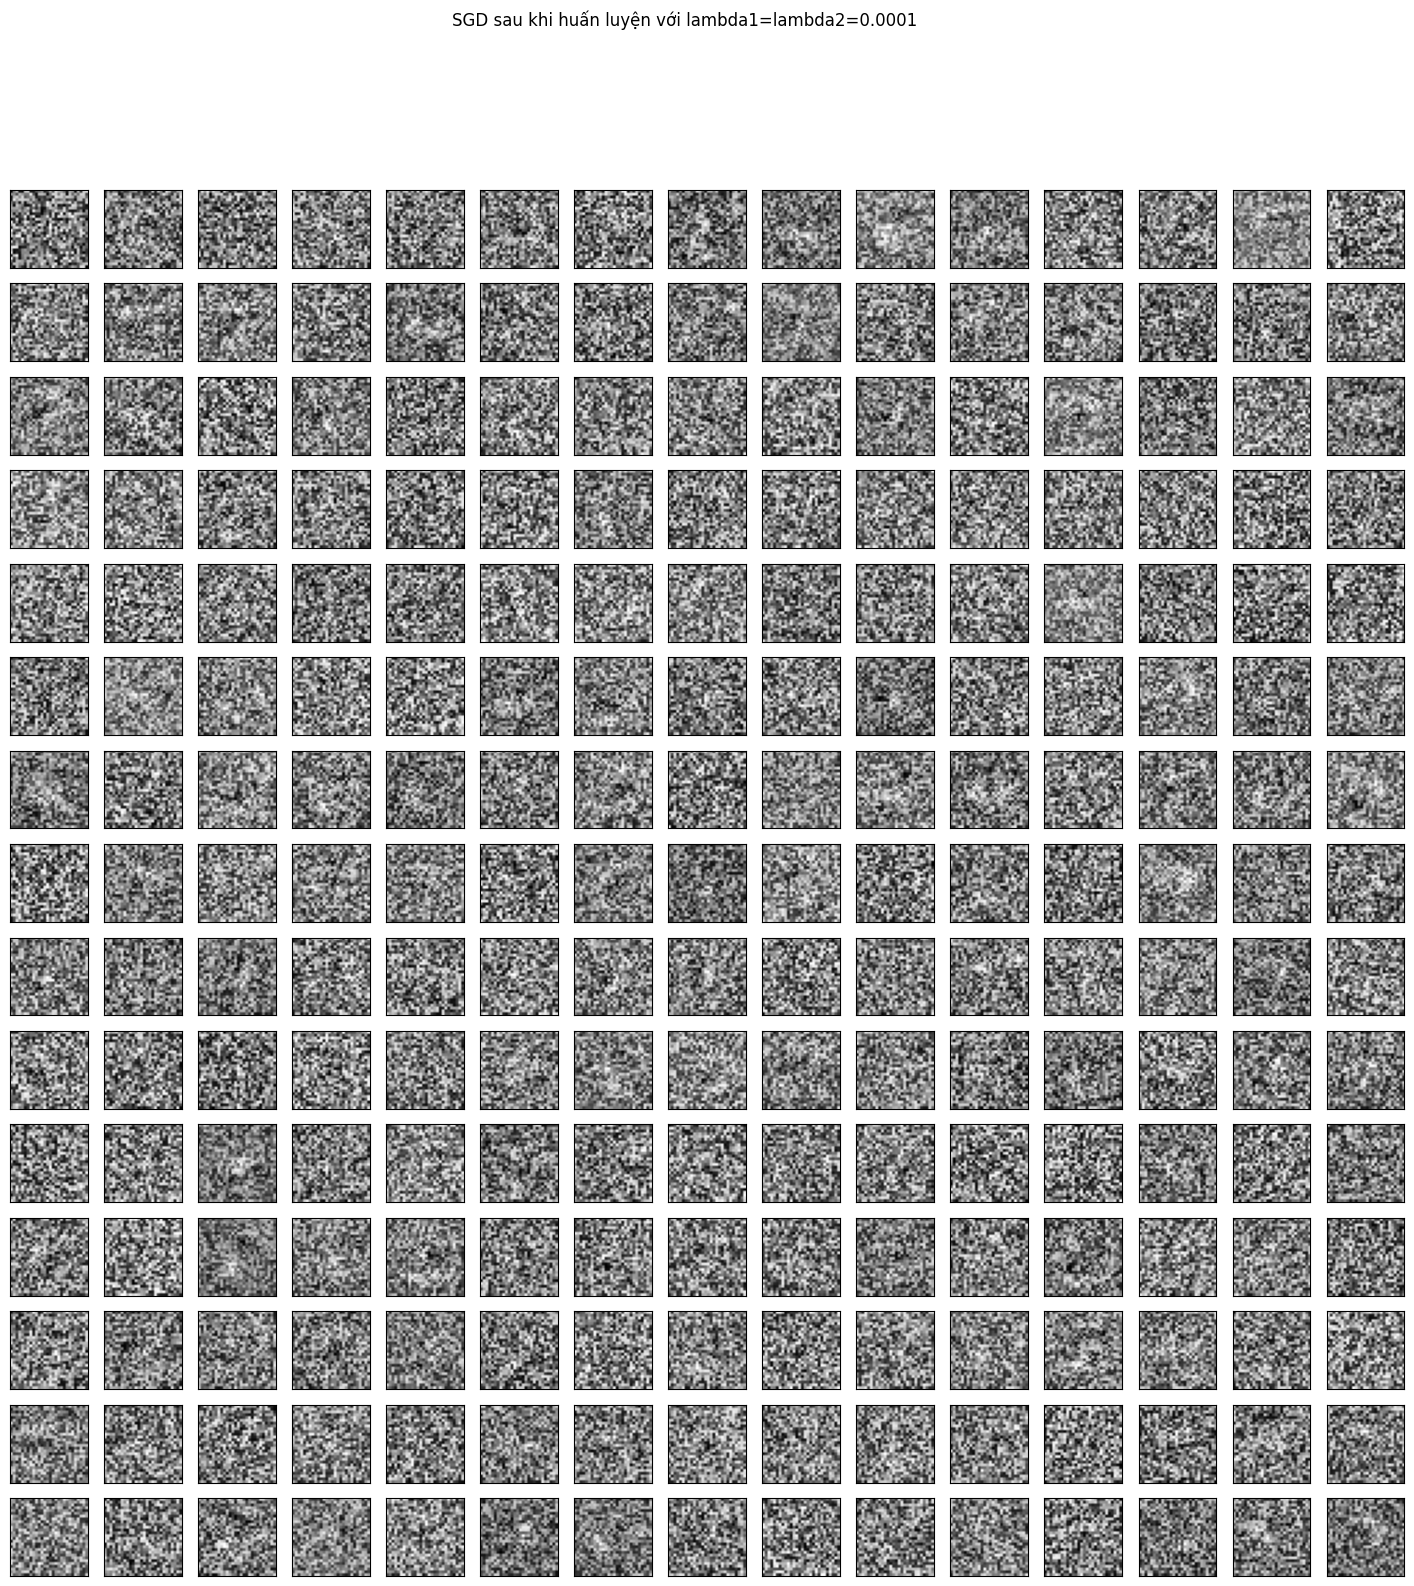

In [28]:
from matplotlib import pylab

# Lấy trọng số của lớp ẩn đầu tiên (kernel của dense1)
images = model.dense1.get_weights()[0]  # Kích thước: (784, num_hidden_units)

# Tạo một figure lớn để hiển thị các ảnh
pylab.figure(figsize=(18, 18))

# Chọn ngẫu nhiên 225 neuron trong lớp ẩn
indices = np.random.choice(num_hidden_units, 225, replace=False)

for j in range(225):
    pylab.subplot(15, 15, j + 1)
    # Lấy trọng số kết nối với neuron thứ indices[j] và reshape về kích thước ảnh
    image = images[:, indices[j]].reshape((image_size, image_size))
    pylab.imshow(image, cmap='gray')
    pylab.xticks([]), pylab.yticks([])

# Thêm tiêu đề cho figure
pylab.suptitle('SGD sau khi huấn luyện với lambda1=lambda2=' + str(lambda1))

# Hiển thị figure
pylab.show()

13 13 13 13


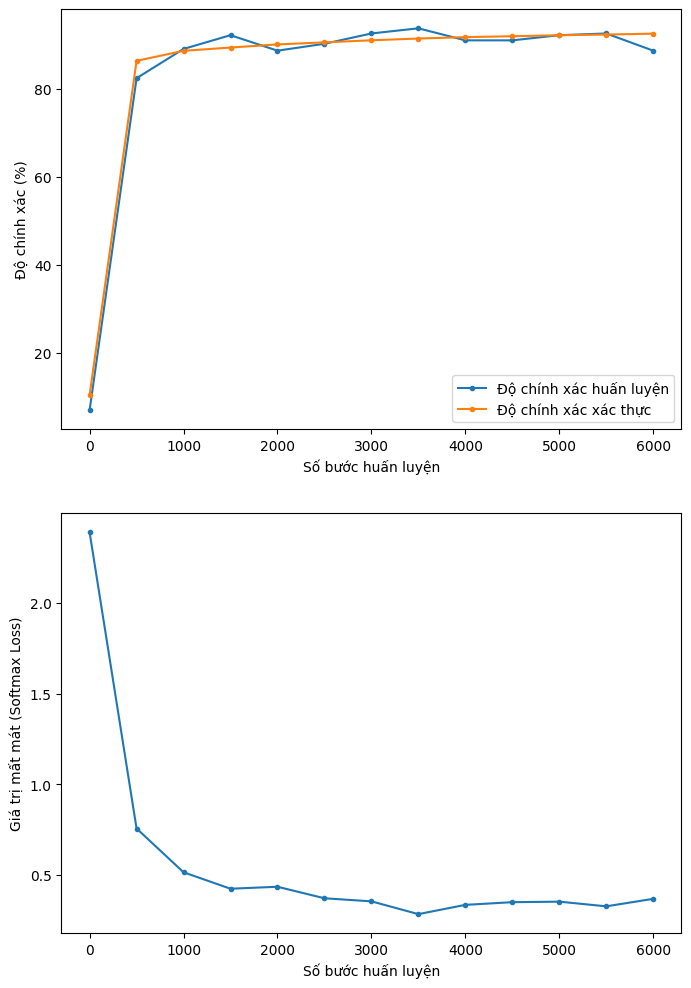

In [ ]:
import matplotlib.pyplot as pylab

# Tạo danh sách các bước huấn luyện mà chúng ta đã ghi nhận giá trị
steps = range(0, num_steps, 500)

# Kiểm tra độ dài của các danh sách để đảm bảo chúng khớp nhau
print(len(steps), len(train_accuracy_list), len(validation_accuracy_list), len(loss_list))

# Tạo figure với kích thước 8x12 inch
pylab.figure(figsize=(8, 12))

# Vẽ biểu đồ độ chính xác huấn luyện và xác thực
pylab.subplot(211)
pylab.plot(steps, train_accuracy_list, '.-', label='Độ chính xác huấn luyện')
pylab.plot(steps, validation_accuracy_list, '.-', label='Độ chính xác xác thực')
pylab.xlabel('Số bước huấn luyện')
pylab.ylabel('Độ chính xác (%)')
pylab.legend(loc='lower right')

# Vẽ biểu đồ mất mát
pylab.subplot(212)
pylab.plot(steps, loss_list, '.-')
pylab.xlabel('Số bước huấn luyện')
pylab.ylabel('Giá trị mất mát (Softmax Loss)')

# Hiển thị biểu đồ
pylab.show()